In [3]:
# imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set options
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [4]:
# load data
base_path = os.getcwd()
df_master = pd.read_csv(os.path.join(base_path, "data", "processed", "master_file.csv"), parse_dates=["FlightDate"])

# check basic info
print(df_master.info())

# check missing values
print("Missing values:\n", df_master.isnull().sum())

# check duplicates
print("Duplicate rows:", df_master.duplicated().sum())

# basic statistics
print(df_master.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6825926 entries, 0 to 6825925
Data columns (total 40 columns):
 #   Column              Dtype         
---  ------              -----         
 0   FlightDate          datetime64[ns]
 1   Day_Of_Week         int64         
 2   Airline             object        
 3   Tail_Number         object        
 4   Dep_Airport         object        
 5   Dep_CityName        object        
 6   DepTime_label       object        
 7   Dep_Delay           int64         
 8   Dep_Delay_Tag       int64         
 9   Dep_Delay_Type      object        
 10  Arr_Airport         object        
 11  Arr_CityName        object        
 12  Arr_Delay           int64         
 13  Arr_Delay_Type      object        
 14  Flight_Duration     int64         
 15  Distance_type       object        
 16  Delay_Carrier       int64         
 17  Delay_Weather       int64         
 18  Delay_NAS           int64         
 19  Delay_Security      int64         
 20  De

In [5]:
# drop duplicates and check 
df_master = df_master.drop_duplicates()
print("Duplicate rows:", df_master.duplicated().sum())

Duplicate rows: 0


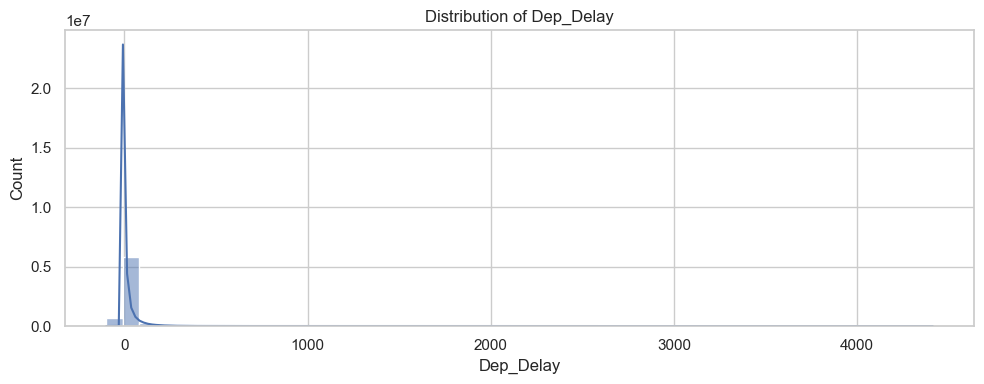

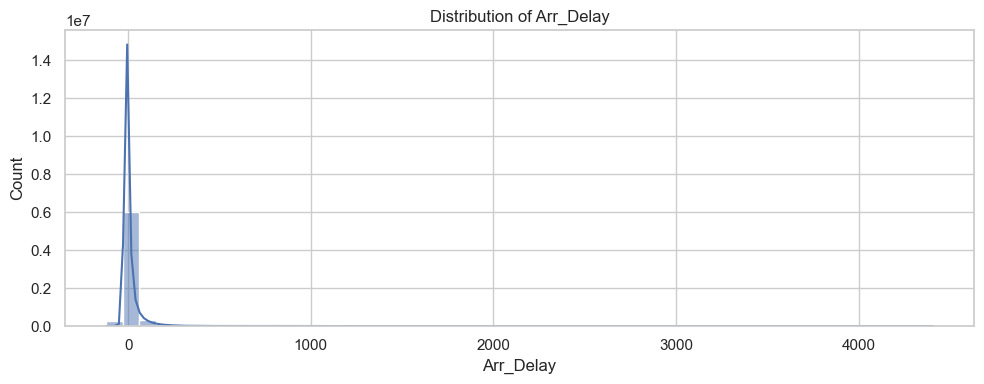

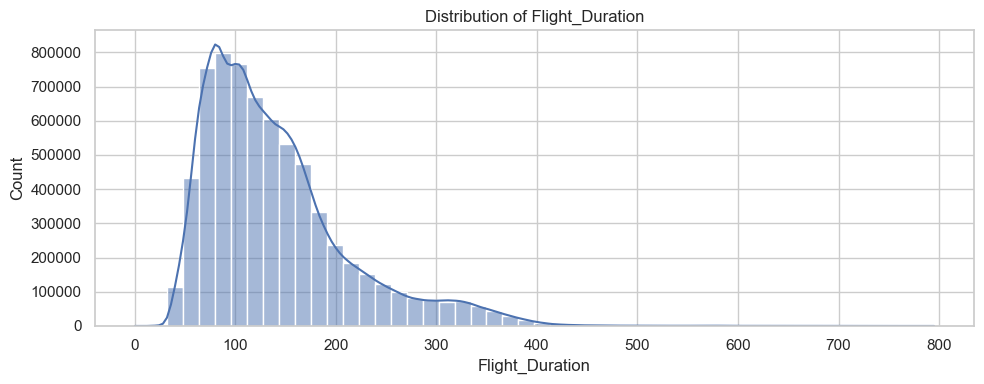

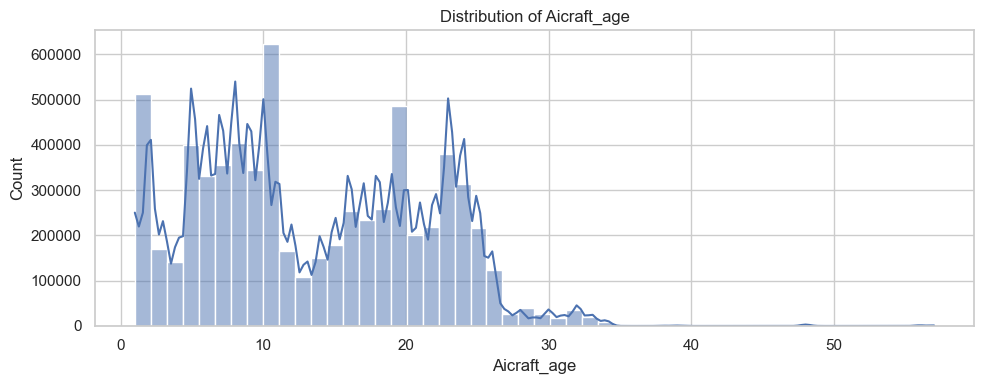

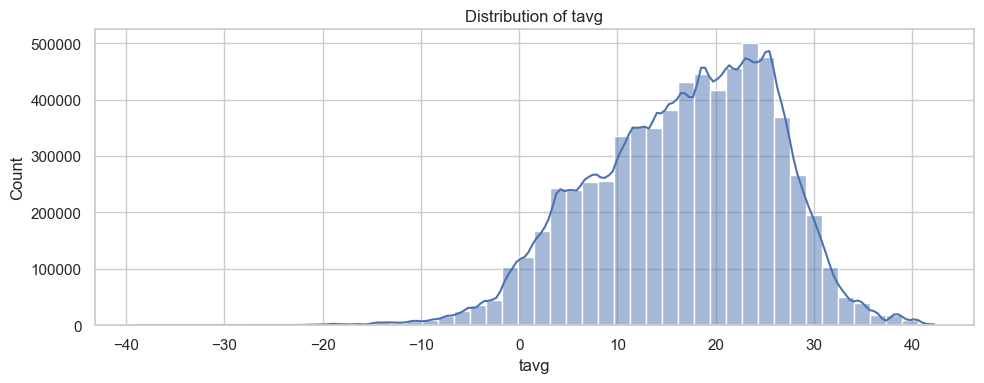

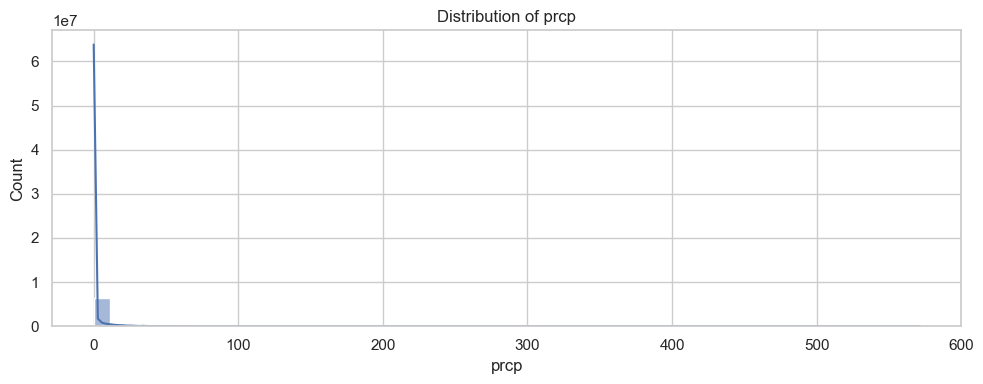

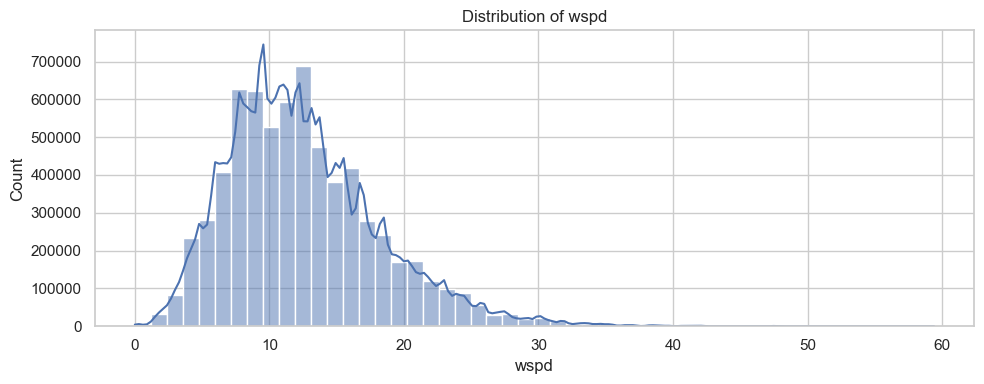

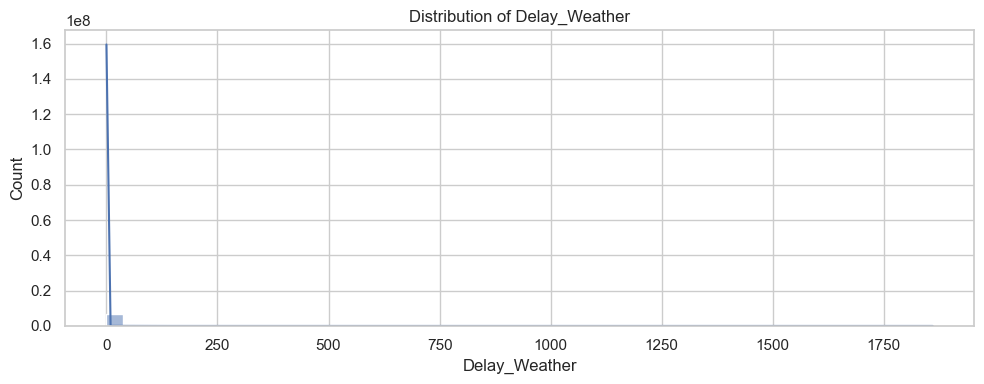

In [6]:
# plots for numerical features
numerical_cols = ["Dep_Delay", "Arr_Delay", "Flight_Duration", "Aicraft_age", "tavg", "prcp", "wspd", "Delay_Weather"]
for col in numerical_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(df_master[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


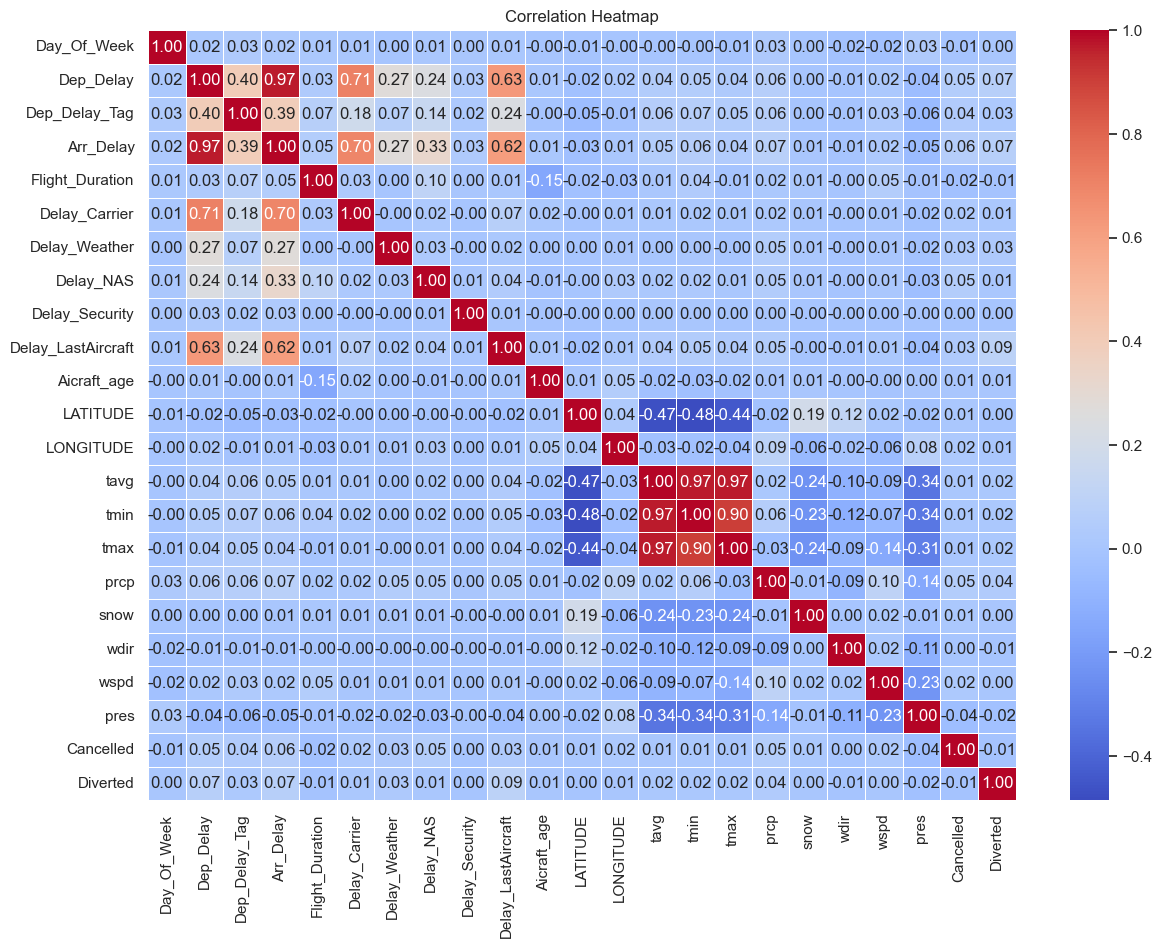

Arr_Delay  Dep_Delay    0.970677
tavg       tmin         0.970469
           tmax         0.969549
tmax       tmin         0.903431
dtype: float64
['tmax', 'Arr_Delay', 'tavg']


In [7]:
# corr matrix
plt.figure(figsize=(14, 10))
corr = df_master.select_dtypes(include=["float64", "int64"]).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# adjsut threshold if necessary
corr_pairs = corr.abs().unstack()
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) < corr_pairs.index.get_level_values(1)]
corr_pairs = corr_pairs.dropna()
strong_corr = corr_pairs[corr_pairs>0.8].sort_values(ascending=False)
features_to_drop = list({pair[0] for pair in strong_corr.index})

# print corr
print(strong_corr)
print(features_to_drop)

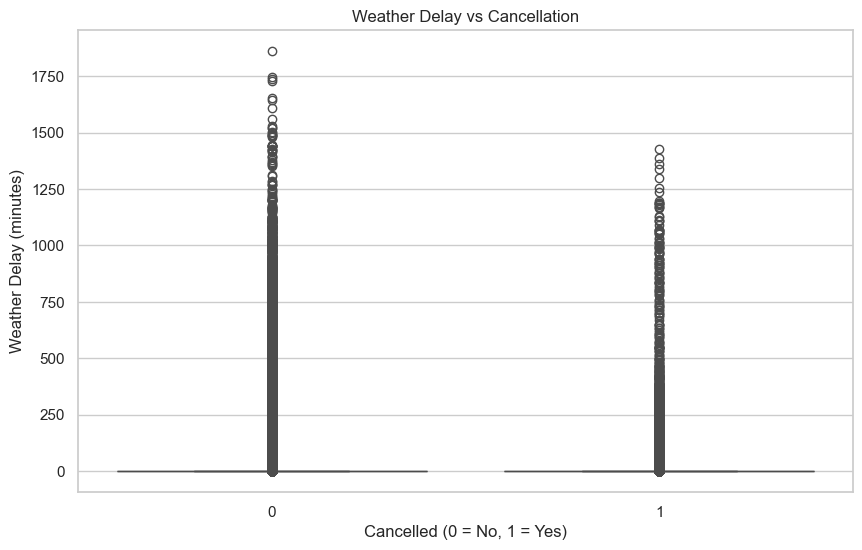

In [8]:
# weather vs cancellation
plt.figure(figsize=(10, 6))
sns.boxplot(x="Cancelled", y="Delay_Weather", data=df_master)
plt.title("Weather Delay vs Cancellation")
plt.xlabel("Cancelled (0 = No, 1 = Yes)")
plt.ylabel("Weather Delay (minutes)")
plt.show()

c:\Users\apeco\Documents\Python\flight-_delay_analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


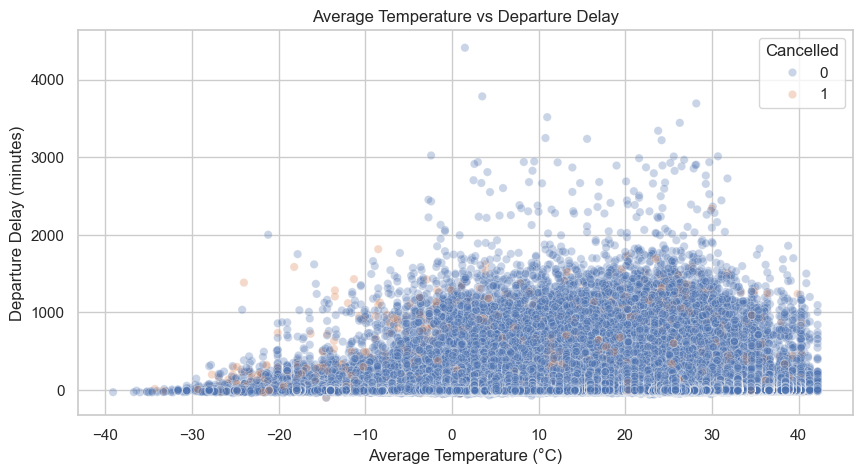

In [9]:
# avg temp vs departure delay
plt.figure(figsize=(10, 5))
sns.scatterplot(x="tavg", y="Dep_Delay", hue="Cancelled", data=df_master, alpha=0.3)
plt.title("Average Temperature vs Departure Delay")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Departure Delay (minutes)")
plt.show()

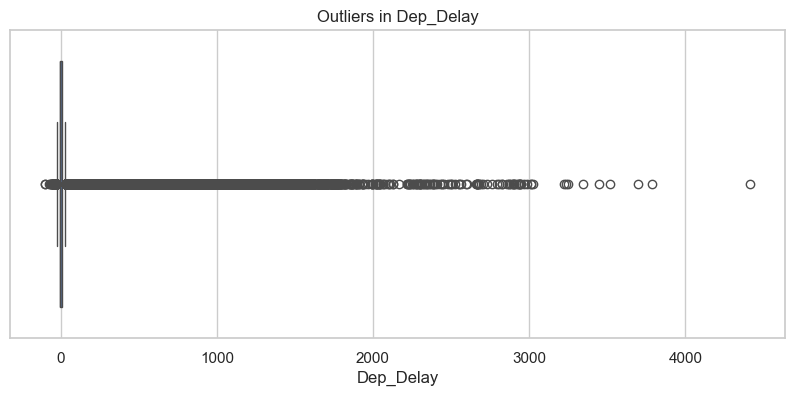

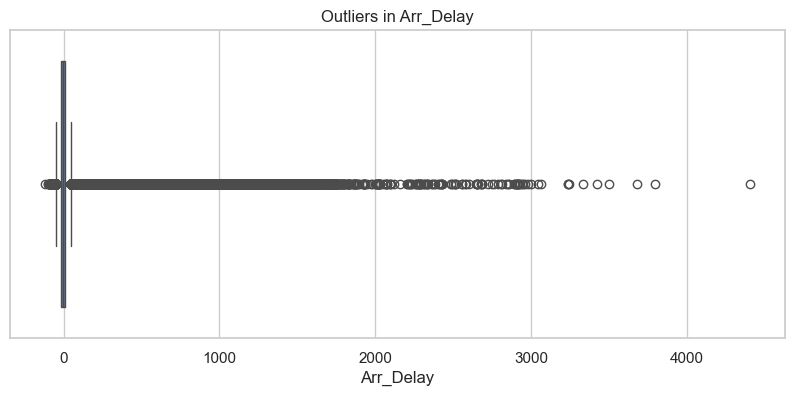

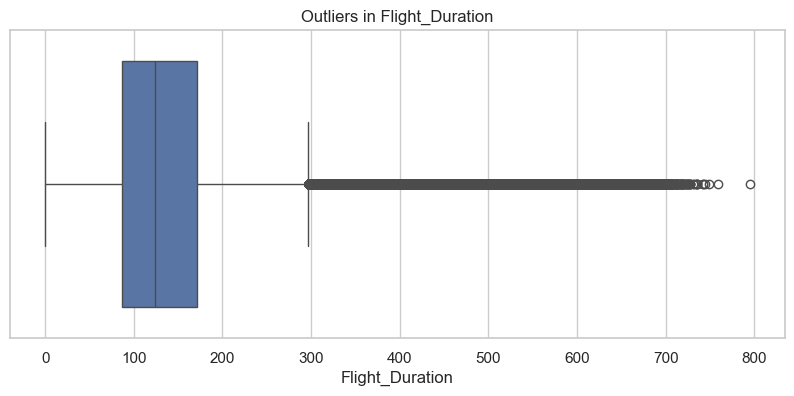

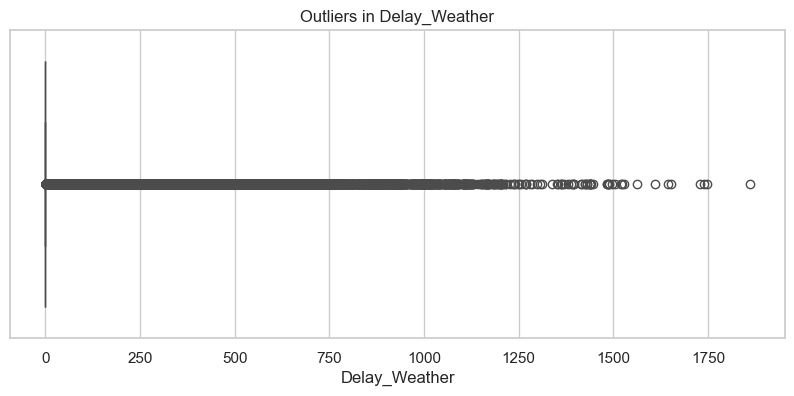

In [10]:
# delay outliers
for col in ["Dep_Delay", "Arr_Delay", "Flight_Duration", "Delay_Weather"]:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df_master[col])
    plt.title(f"Outliers in {col}")
    plt.show()

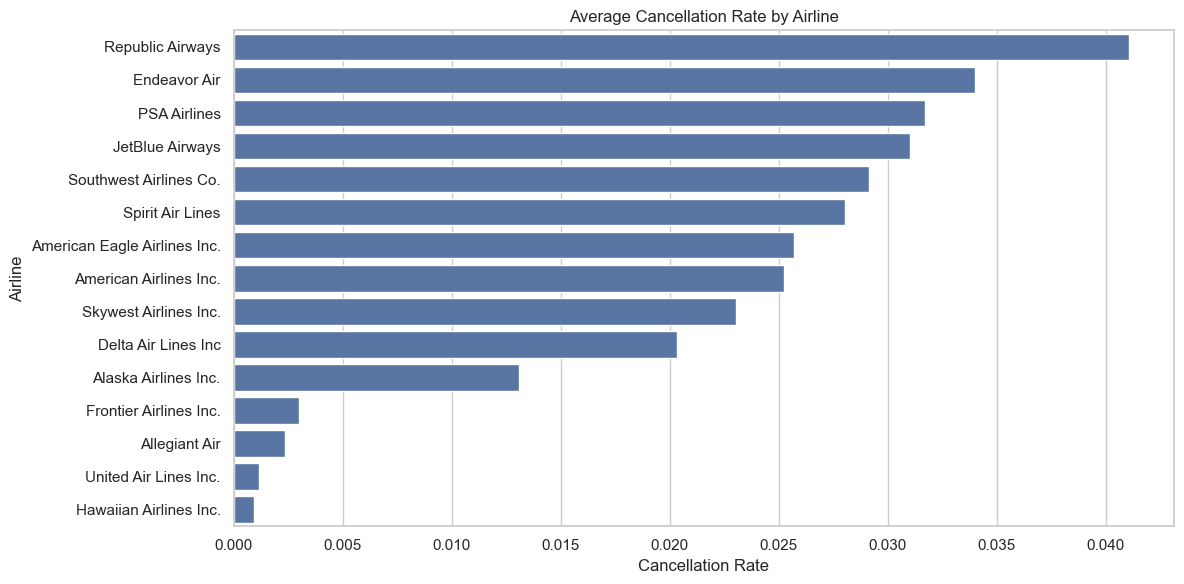

In [11]:
# avg cancaellation rate by airline
plt.figure(figsize=(12, 6))
airline_cancel = df_master.groupby("Airline")["Cancelled"].mean().sort_values(ascending=False)
sns.barplot(x=airline_cancel, y=airline_cancel.index)
plt.title("Average Cancellation Rate by Airline")
plt.xlabel("Cancellation Rate")
plt.ylabel("Airline")
plt.tight_layout()
plt.show()

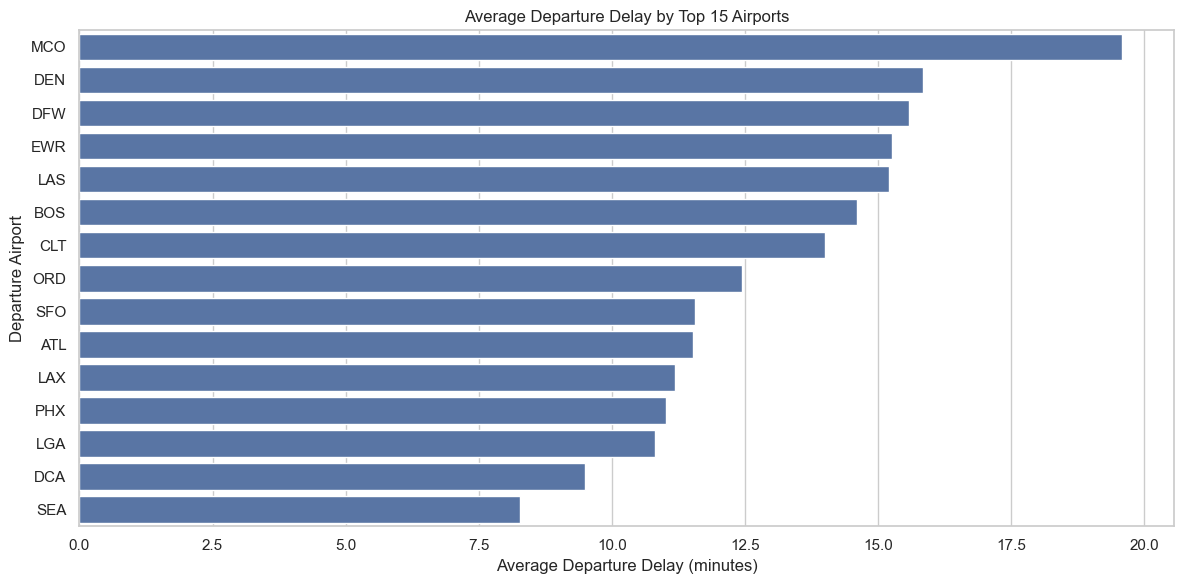

In [12]:
# airport-related delays (departure)
top_airports = df_master['Dep_Airport'].value_counts().head(15).index
airport_delays = df_master[df_master['Dep_Airport'].isin(top_airports)].groupby('Dep_Airport')["Dep_Delay"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=airport_delays, y=airport_delays.index)
plt.title("Average Departure Delay by Top 15 Airports")
plt.xlabel("Average Departure Delay (minutes)")
plt.ylabel("Departure Airport")
plt.tight_layout()
plt.show()


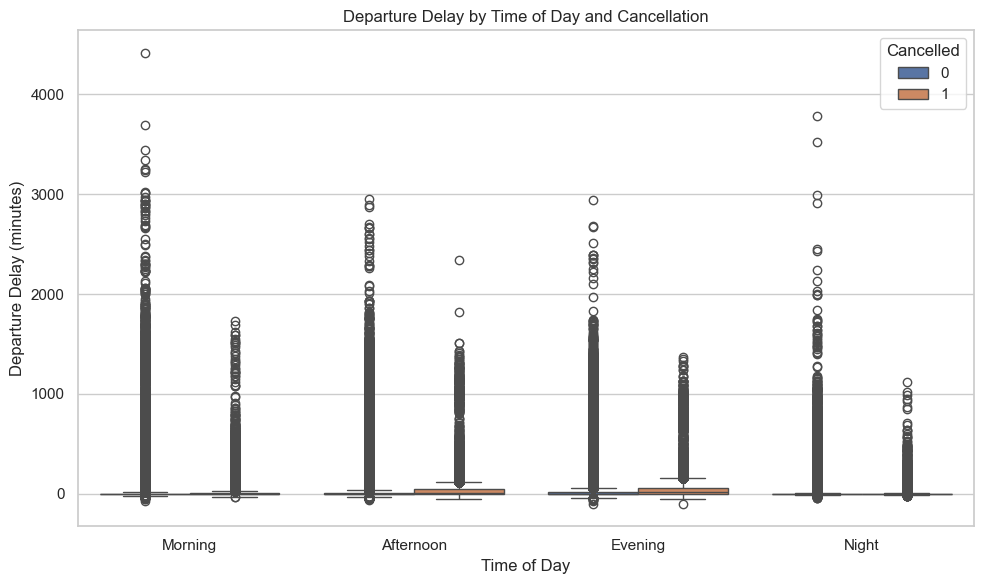

In [13]:
# time of day impact on cancellations
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_master, x="DepTime_label", y="Dep_Delay", hue="Cancelled")
plt.title("Departure Delay by Time of Day and Cancellation")
plt.xlabel("Time of Day")
plt.ylabel("Departure Delay (minutes)")
plt.tight_layout()
plt.show()

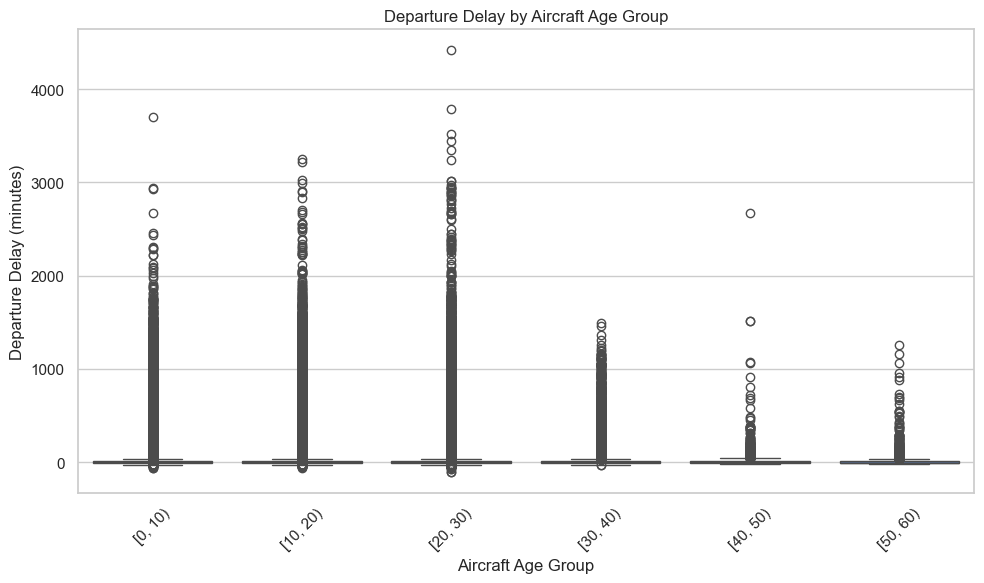

In [14]:
# aircraft age vs delay
df_master["Aircraft_Age_Group"] = pd.cut(df_master["Aicraft_age"], bins=[0,10,20,30,40,50,60], right=False)

plt.figure(figsize=(10, 6))
sns.boxplot(x="Aircraft_Age_Group", y="Dep_Delay", data=df_master)
plt.title("Departure Delay by Aircraft Age Group")
plt.xlabel("Aircraft Age Group")
plt.ylabel("Departure Delay (minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


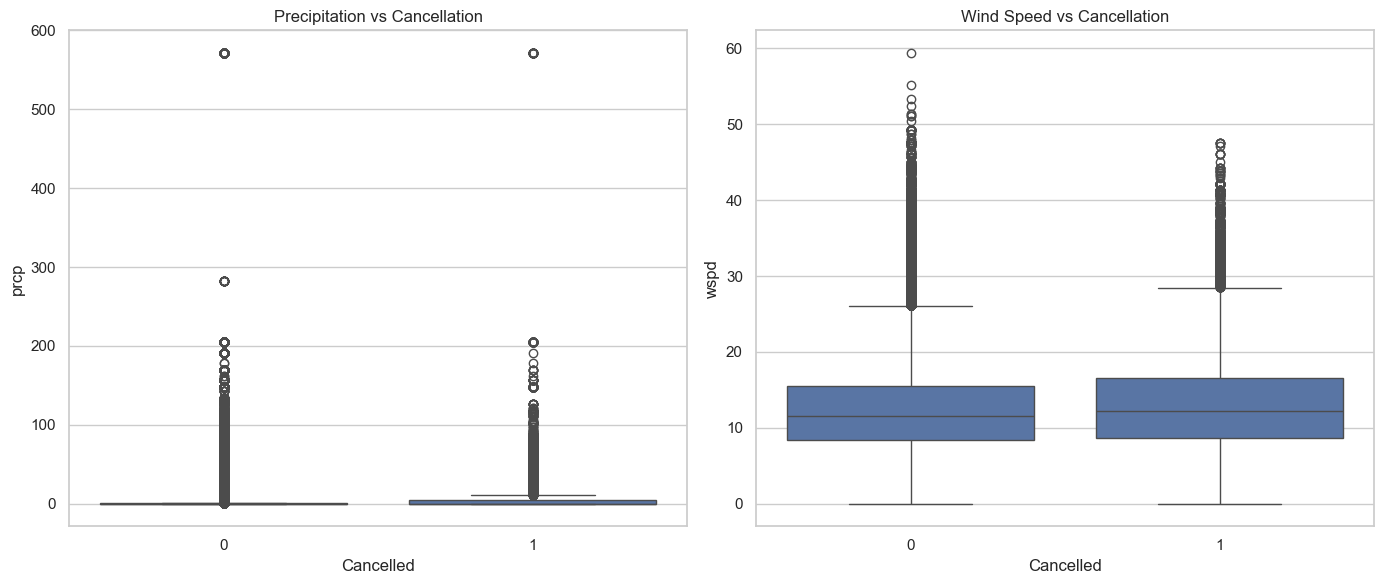

In [15]:
# weather: precipitation and wind speed vs cancellations
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=df_master, x="Cancelled", y="prcp", ax=axs[0])
axs[0].set_title("Precipitation vs Cancellation")

sns.boxplot(data=df_master, x="Cancelled", y="wspd", ax=axs[1])
axs[1].set_title("Wind Speed vs Cancellation")

plt.tight_layout()
plt.show()


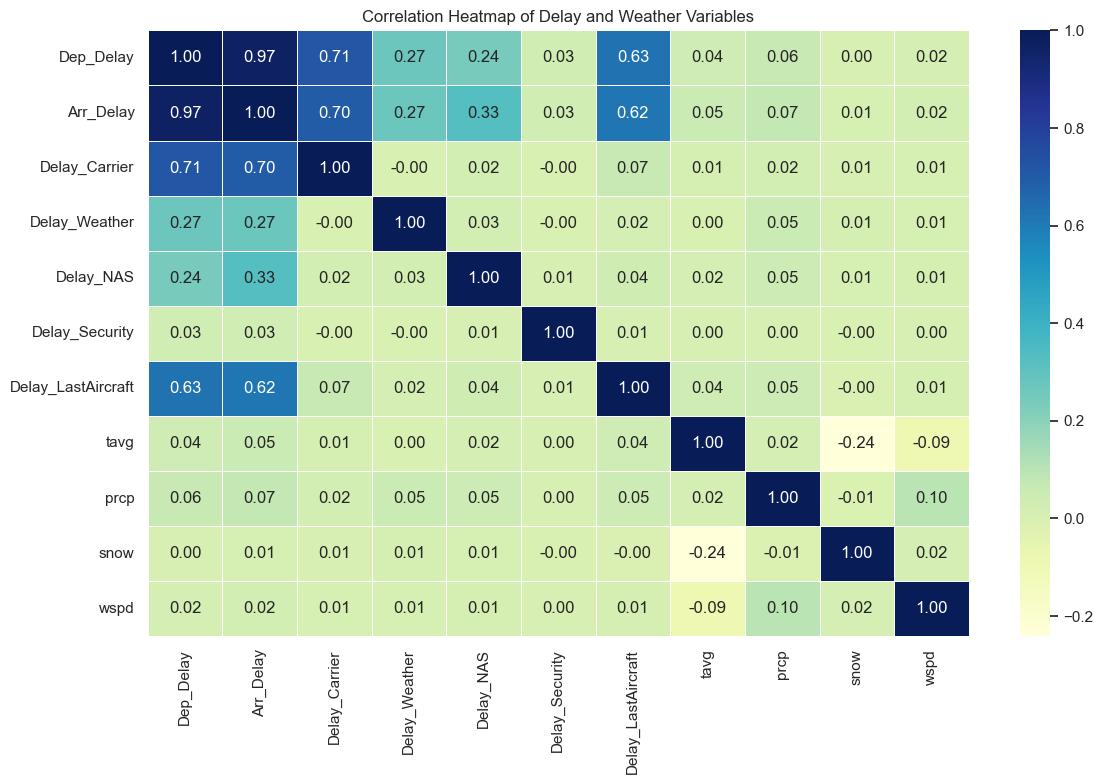

In [16]:
# heatmap for delay-related features
delay_features = [
    "Dep_Delay", "Arr_Delay", "Delay_Carrier", "Delay_Weather", "Delay_NAS",
    "Delay_Security", "Delay_LastAircraft", "tavg", "prcp", "snow", "wspd"
]
plt.figure(figsize=(12, 8))
sns.heatmap(df_master[delay_features].corr(), annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Delay and Weather Variables")
plt.tight_layout()
plt.show()

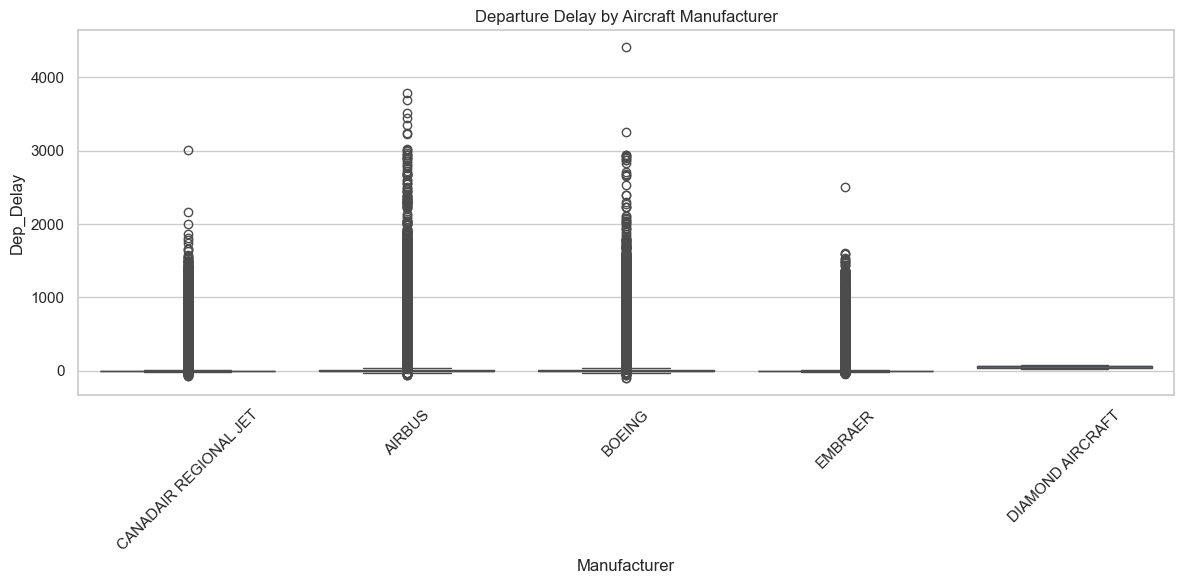

In [17]:
# delay by manufacturer
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_master[df_master['Manufacturer'].isin(df_master['Manufacturer'].value_counts().head(10).index)],
            x="Manufacturer", y="Dep_Delay")
plt.xticks(rotation=45)
plt.title("Departure Delay by Aircraft Manufacturer")
plt.tight_layout()
plt.show()

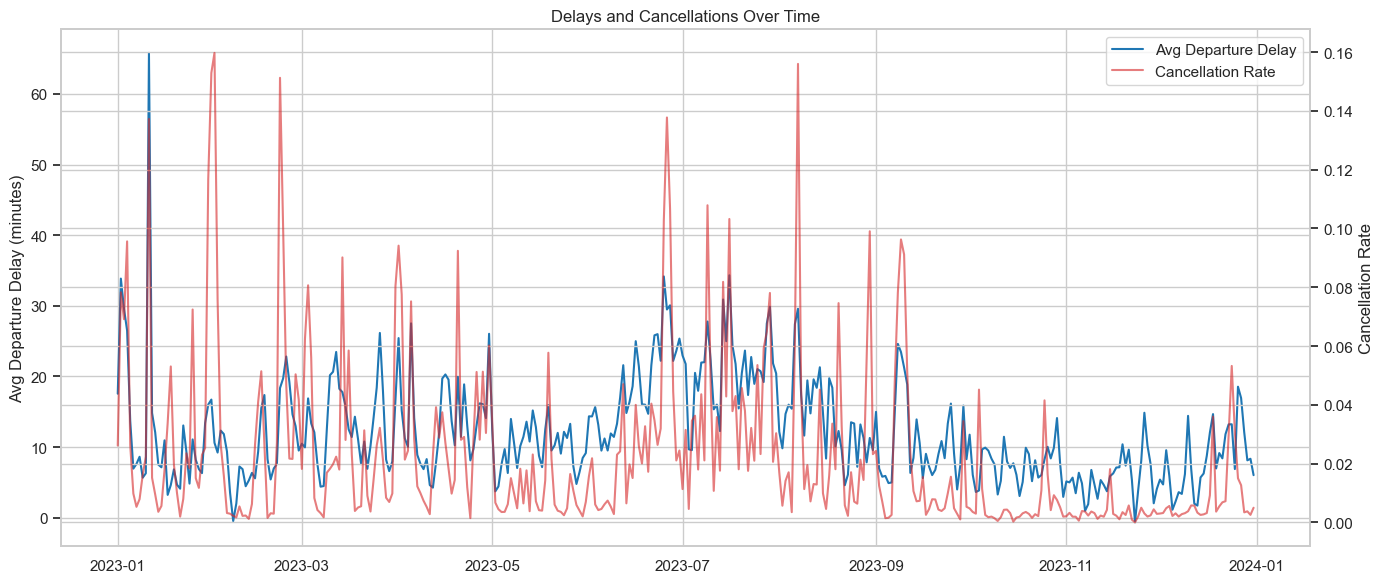

In [18]:
# delays and cancellations over time
daily_summary = df_master.groupby("FlightDate").agg({
    "Dep_Delay": "mean",
    "Cancelled": "mean",
    "Diverted": "mean"
}).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(daily_summary["FlightDate"], daily_summary["Dep_Delay"], label="Avg Departure Delay", color="tab:blue")
ax2 = ax1.twinx()
ax2.plot(daily_summary["FlightDate"], daily_summary["Cancelled"], label="Cancellation Rate", color="tab:red", alpha=0.6)
ax1.set_ylabel("Avg Departure Delay (minutes)")
ax2.set_ylabel("Cancellation Rate")
plt.title("Delays and Cancellations Over Time")
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()

In [19]:
# drop unncessary features and save cleaned df
columns_to_drop = [
    "Tail_Number", "Dep_CityName", "Arr_CityName",
    "Dep_Delay_Tag", "Dep_Delay_Type", "Arr_Delay_Type",
    "Model", "CITY", "COUNTRY", "STATE", "LATITUDE", "LONGITUDE"
]

df_cleaned = df_master.drop(columns=columns_to_drop, errors="ignore")

# Save cleaned file for modeling
cleaned_output_path = os.path.join(base_path, "data", "processed", "df_cleaned_ready_for_modeling.csv")
df_cleaned.to_csv(cleaned_output_path, index=False)
print(f"✅ Dataset saved to: {cleaned_output_path}")

✅ Dataset saved to: c:\Users\apeco\Documents\Python\flight-_delay_analysis\data\processed\df_cleaned_ready_for_modeling.csv
